In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dropout, Dense


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.0 at tensorflow/core/framewo

In [4]:
df = pd.read_csv("C:/Users/muthu/Downloads/TSLA.csv")

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [6]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.3+ KB


In [9]:
df.columns = df.columns.str.strip()  # remove spaces
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)


In [10]:

# Select only the close/adj close price
df = df[['Adj Close']].rename(columns={'Adj Close':'Close'})


In [11]:


scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df)


In [12]:
#create sequences function
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i + window])
        y.append(data[i + window])
    return np.array(X), np.array(y)


In [13]:

#build train and test set for 1,5,10 days
# 1‑day window
X1, y1 = create_sequences(scaled_data, window=1)

# 5‑day
X5, y5 = create_sequences(scaled_data, window=5)

# 10‑day
X10, y10 = create_sequences(scaled_data, window=10)

def train_test_split(X, y, ratio=0.8):
    idx = int(len(X) * ratio)
    return X[:idx], X[idx:], y[:idx], y[idx:]

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1)
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y5)
X10_train, X10_test, y10_train, y10_test = train_test_split(X10, y10)


In [15]:
#Reshape for RNN and LSTM

X1_train = X1_train.reshape(X1_train.shape[0], X1_train.shape[1], 1)
X1_test  = X1_test.reshape(X1_test.shape[0],  X1_test.shape[1], 1)

X5_train = X5_train.reshape(X5_train.shape[0], X5_train.shape[1], 1)
X5_test  = X5_test.reshape(X5_test.shape[0],  X5_test.shape[1], 1)

X10_train = X10_train.reshape(X10_train.shape[0], X10_train.shape[1], 1)
X10_test  = X10_test.reshape(X10_test.shape[0],  X10_test.shape[1], 1)


In [16]:
def build_rnn(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(SimpleRNN(units, input_shape=(None,1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model


In [17]:
def build_lstm(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units, input_shape=(None,1)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mean_squared_error'
    )
    return model


In [18]:
param_grid = {
    "model__units": [50, 100],
    "model__dropout_rate": [0.2, 0.4],
    "optimizer__learning_rate": [1e-4, 1e-3],
    "fit__batch_size": [32, 64],
    "fit__epochs": [20, 40]
}


In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

rnn_reg = KerasRegressor(
    model=build_rnn,
    callbacks=[EarlyStopping, ModelCheckpoint],
    callbacks__0__monitor="val_loss",          # First callback (EarlyStopping)
    callbacks__0__patience=5,
    callbacks__0__restore_best_weights=True,
    callbacks__1__filepath="best_rnn_model.h5", # Second callback (ModelCheckpoint)
    callbacks__1__monitor="val_loss",
    callbacks__1__save_best_only=True,
    fit__validation_split=0.2,
    verbose=0
)


In [20]:


grid_rnn1 = GridSearchCV(
    estimator=rnn_reg,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    verbose=2
)




In [21]:
grid_rnn1_result = grid_rnn1.fit(
    X1_train, y1_train)
print("Best SimpleRNN 1‑day:", grid_rnn1_result.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  10.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   3.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   9.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   2.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   2.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   9.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\ma\core.py:2892: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best SimpleRNN 1‑day: {'fit__batch_size': 32, 'fit__epochs': 40, 'model__dropout_rate': 0.2, 'model__units': 100, 'optimizer__learning_rate': 0.0001}


In [22]:
best_rnn1 = grid_rnn1_result.best_estimator_
pred_rnn1 = best_rnn1.predict(X1_test)
pred_rnn1_inv = scaler.inverse_transform(pred_rnn1.reshape(-1,1))
true1_inv = scaler.inverse_transform(y1_test.reshape(-1,1))
print("RNN 1‑day MSE:", mean_squared_error(true1_inv, pred_rnn1_inv))


RNN 1‑day MSE: 161.77784672700074


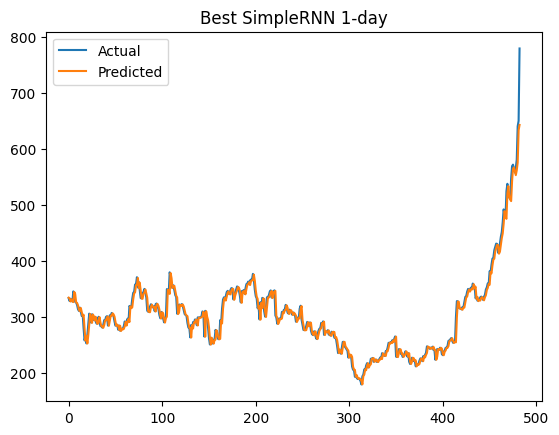

In [23]:


plt.plot(true1_inv, label="Actual")
plt.plot(pred_rnn1_inv, label="Predicted")
plt.title("Best SimpleRNN 1‑day")
plt.legend()
plt.show()

In [24]:
grid_rnn5_result = GridSearchCV(rnn_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X5_train, y5_train)
print("Best SimpleRNN 5‑day:", grid_rnn5_result.best_params_)




Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   9.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   2.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   2.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   2.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   2.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   2.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best SimpleRNN 5‑day: {'fit__batch_size': 32, 'fit__epochs': 20, 'model__dropout_rate': 0.2, 'model__units': 100, 'optimizer__learning_rate': 0.001}


In [25]:
best_rnn5 = grid_rnn5_result.best_estimator_
pred_rnn5 = best_rnn5.predict(X5_test)
pred_rnn5_inv = scaler.inverse_transform(pred_rnn5.reshape(-1,1))
true5_inv = scaler.inverse_transform(y5_test.reshape(-1,1))
print("RNN 5‑days MSE:", mean_squared_error(true5_inv, pred_rnn5_inv))


RNN 5‑days MSE: 246.71255509925547


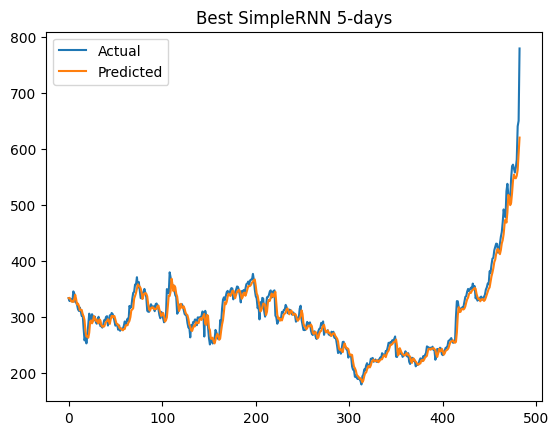

In [26]:


plt.plot(true5_inv, label="Actual")
plt.plot(pred_rnn5_inv, label="Predicted")
plt.title("Best SimpleRNN 5‑days")
plt.legend()
plt.show()

In [27]:
grid_rnn10_result = GridSearchCV(rnn_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X10_train, y10_train)
print("Best SimpleRNN 10‑day:", grid_rnn10_result.best_params_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  17.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   8.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  11.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  18.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best SimpleRNN 10‑day: {'fit__batch_size': 32, 'fit__epochs': 40, 'model__dropout_rate': 0.4, 'model__units': 50, 'optimizer__learning_rate': 0.001}


In [28]:
best_rnn10 = grid_rnn10_result.best_estimator_
pred_rnn10 = best_rnn10.predict(X10_test)
pred_rnn10_inv = scaler.inverse_transform(pred_rnn10.reshape(-1,1))
true10_inv = scaler.inverse_transform(y10_test.reshape(-1,1))
print("RNN 10‑days MSE:", mean_squared_error(true10_inv, pred_rnn10_inv))


RNN 10‑days MSE: 249.82905566294073


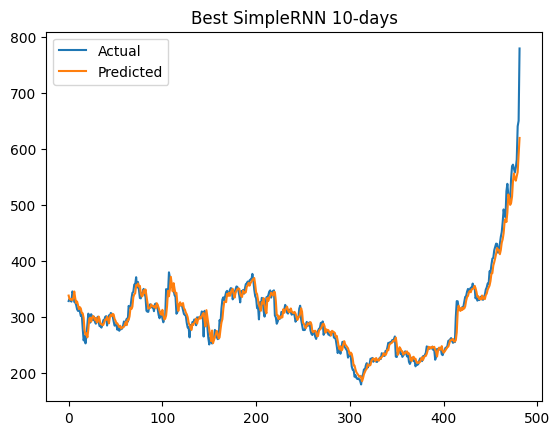

In [29]:


plt.plot(true10_inv, label="Actual")
plt.plot(pred_rnn10_inv, label="Predicted")
plt.title("Best SimpleRNN 10‑days")
plt.legend()
plt.show()

In [30]:


lstm_reg = KerasRegressor(
    model=build_lstm,
    
    # List of callback *classes* (SciKeras will instantiate them)
    callbacks=[EarlyStopping, ModelCheckpoint],
    
    # Configure the first callback (EarlyStopping)
    callbacks__0__monitor="val_loss",
    callbacks__0__patience=5,
    callbacks__0__restore_best_weights=True,
    
    # Configure the second callback (ModelCheckpoint)
    callbacks__1__filepath="best_lstm_model.h5",
    callbacks__1__monitor="val_loss",
    callbacks__1__save_best_only=True,
    
    # Validation split to allow val_loss monitoring
    fit__validation_split=0.2,
    
    verbose=0
)



grid_lstm1_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X1_train, y1_train)
print("Best LSTM 1‑day:", grid_lstm1_result.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   9.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   6.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  29.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   9.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   9.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  10.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  10.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  13.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  10.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  14.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  20.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   9.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  31.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  19.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  13.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  51.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  10.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  10.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  10.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   8.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   9.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  20.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  20.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  14.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  37.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  17.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  13.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=  13.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  11.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  10.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  13.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  15.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  12.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  10.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best LSTM 1‑day: {'fit__batch_size': 64, 'fit__epochs': 40, 'model__dropout_rate': 0.2, 'model__units': 100, 'optimizer__learning_rate': 0.001}


In [31]:
best_lstm1 = grid_lstm1_result.best_estimator_
pred_lstm1 = best_lstm1.predict(X1_test)
pred_lstm1_inv = scaler.inverse_transform(pred_lstm1.reshape(-1,1))
actual1 = scaler.inverse_transform(y1_test.reshape(-1,1))

print("1‑day LSTM MSE:", mean_squared_error(actual1, pred_lstm1_inv))


1‑day LSTM MSE: 147.41213235114216


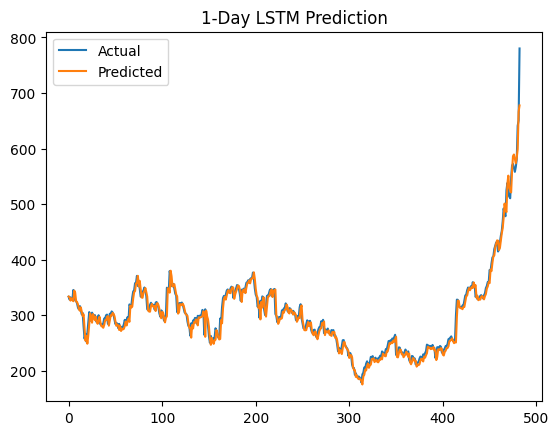

In [32]:

plt.plot(actual1, label="Actual")
plt.plot(pred_lstm1_inv, label="Predicted")
plt.legend()
plt.title("1‑Day LSTM Prediction")
plt.show()


In [33]:
grid_lstm5_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X5_train, y5_train)
print("Best LSTM 5‑day:", grid_lstm5_result.best_params_)



Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   9.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=  10.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   9.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   9.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   8.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   5.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time= 4.0min


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  11.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  13.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   9.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  20.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  24.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  14.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  11.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  18.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  15.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   9.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   4.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   2.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   2.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   4.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   3.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   2.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   2.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   2.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time= 2.9min


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  18.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  32.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  14.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   3.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   4.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best LSTM 5‑day: {'fit__batch_size': 32, 'fit__epochs': 40, 'model__dropout_rate': 0.4, 'model__units': 100, 'optimizer__learning_rate': 0.0001}


In [34]:
best_lstm5 = grid_lstm5_result.best_estimator_
pred_lstm5 = best_lstm5.predict(X5_test)
pred_lstm5_inv = scaler.inverse_transform(pred_lstm5.reshape(-1,1))
actual5 = scaler.inverse_transform(y5_test.reshape(-1,1))

print("5‑days LSTM MSE:", mean_squared_error(actual5, pred_lstm5_inv))


5‑days LSTM MSE: 342.8926456524471


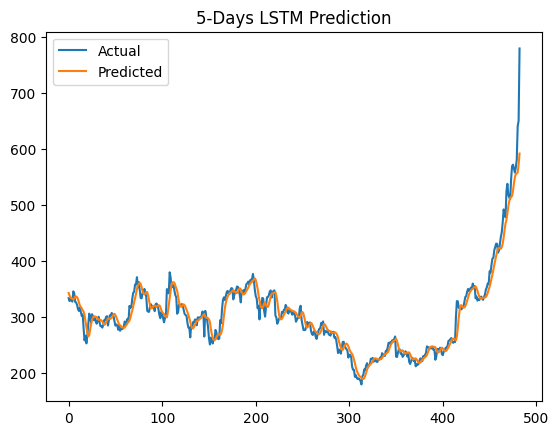

In [35]:

plt.plot(actual5, label="Actual")
plt.plot(pred_lstm5_inv, label="Predicted")
plt.legend()
plt.title("5‑Days LSTM Prediction")
plt.show()


In [36]:
grid_lstm10_result = GridSearchCV(lstm_reg, param_grid, scoring="neg_mean_squared_error", cv=3, verbose=2).fit(X10_train, y10_train)
print("Best LSTM 10‑day:", grid_lstm10_result.best_params_)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  12.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  16.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  17.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  17.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   7.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=  10.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=  12.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  13.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  31.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  16.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   9.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  10.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   9.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  11.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  13.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  11.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   9.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  12.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   7.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=  16.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  12.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  13.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   9.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   8.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   9.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  12.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  10.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  12.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=  10.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  10.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  11.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  10.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   9.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   9.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  10.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   9.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   6.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=32, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   9.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   5.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   6.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   3.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   4.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=  12.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   8.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   7.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   9.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=  11.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   3.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   6.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time= 5.0min


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  34.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  14.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  11.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  10.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  10.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   7.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=20, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   6.4s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.0001; total time=   8.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  11.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=  12.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=50, optimizer__learning_rate=0.001; total time=   5.7s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   7.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   6.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.0001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   6.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.2, model__units=100, optimizer__learning_rate=0.001; total time=   5.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   9.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   5.2s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.0001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=  13.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   5.8s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=50, optimizer__learning_rate=0.001; total time=   7.0s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=   8.3s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.0001; total time=  12.6s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  10.1s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  34.5s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


[CV] END fit__batch_size=64, fit__epochs=40, model__dropout_rate=0.4, model__units=100, optimizer__learning_rate=0.001; total time=  17.9s


c:\Users\muthu\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best LSTM 10‑day: {'fit__batch_size': 32, 'fit__epochs': 20, 'model__dropout_rate': 0.4, 'model__units': 100, 'optimizer__learning_rate': 0.0001}


In [37]:
best_lstm10 = grid_lstm10_result.best_estimator_
pred_lstm10 = best_lstm10.predict(X10_test)
pred_lstm10_inv = scaler.inverse_transform(pred_lstm10.reshape(-1,1))
actual10 = scaler.inverse_transform(y10_test.reshape(-1,1))

print("1‑day LSTM MSE:", mean_squared_error(actual10, pred_lstm10_inv))


1‑day LSTM MSE: 513.8748335500608


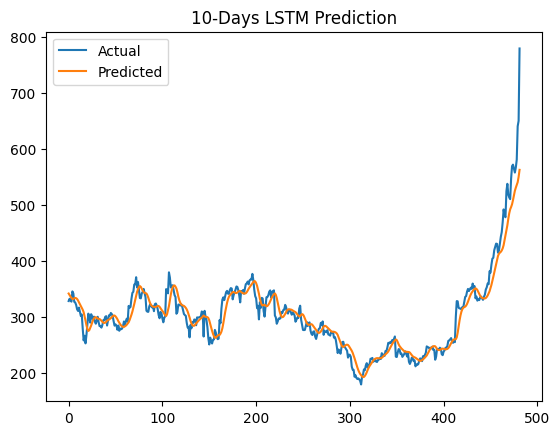

In [38]:

plt.plot(actual10, label="Actual")
plt.plot(pred_lstm10_inv, label="Predicted")
plt.legend()
plt.title("10‑Days LSTM Prediction")
plt.show()
